# <center> <img src="../../img/ITESOLogo.png" alt="ITESO" width="480" height="130"> </center>
# <center> **Departamento de Electrónica, Sistemas e Informática** </center>
---
## <center> Computer Systems Engineering  </center>
---
### <center> Big Data Processing </center>
---
#### <center> **Autumn 2025** </center>
---

**Lab 07**: Structured Streaming with Files 

**Date**: October 10th 2025

**Student Name**: Aura Melina Gutierrez Jimenez

**Professor**: Pablo Camarillo Ramirez

In [1]:
import findspark
findspark.init()

from pyspark.sql import SparkSession

spark = SparkSession.builder \
    .appName("Examples on Structured Streaming (files)") \
    .master("spark://spark-master:7077") \
    .config("spark.ui.port", "4040") \
    .getOrCreate()

sc = spark.sparkContext
sc.setLogLevel("ERROR")
# Optimization (reduce the number of shuffle partitions)
spark.conf.set("spark.sql.shuffle.partitions", "5")

Using Spark's default log4j profile: org/apache/spark/log4j2-defaults.properties
Setting default log level to "WARN".
To adjust logging level use sc.setLogLevel(newLevel). For SparkR, use setLogLevel(newLevel).
25/10/10 02:57:18 WARN NativeCodeLoader: Unable to load native-hadoop library for your platform... using builtin-java classes where applicable


In [2]:
!pwd

/opt/spark/work-dir/labs/lab07


In [ ]:
from pyspark.sql.functions import col, regexp_extract, to_timestamp, current_timestamp
LOG_DIRECTORY = "/opt/spark/work-dir/labs/lab07/streaming_input" 
print(f"[*] Monitoreando el directorio de logs: {LOG_DIRECTORY}")

# 1. Leer el stream de archivos de TEXTO
log_df = spark.readStream \
    .format("text") \
    .load(LOG_DIRECTORY)

# (TIMESTAMP | LEVEL | MESSAGE | NODE)
log_pattern = r"^(\d{4}-\d{2}-\d{2} \d{2}:\d{2}:\d{2}) \| ([A-Z]+) \| (.*) \| (.*)$"

# 2. Aplicar Regex para crear columnas estructuradas
parsed_df = log_df.select(
    regexp_extract(col("value"), log_pattern, 1).alias("timestamp_str"),
    regexp_extract(col("value"), log_pattern, 2).alias("level"),
    regexp_extract(col("value"), log_pattern, 3).alias("message"),
    regexp_extract(col("value"), log_pattern, 4).alias("node")
).withColumn(
    "timestamp", to_timestamp(col("timestamp_str"), "yyyy-MM-dd HH:mm:ss")
).drop("timestamp_str", "value")


# 3. Filtrar y contar "repeated 500 errors"
critical_errors_df = parsed_df.filter(
    (col("level") == "ERROR") & (col("message").contains("500 Internal Server Error"))
)

# Agrupar por nodo y contar las ocurrencias
error_counts = critical_errors_df.groupBy("node").count() \
    .withColumnRenamed("count", "critical_error_count")

alert_df = error_counts.withColumn("last_updated", current_timestamp())


# ESCRITURA AL SINK (CONSOLA) Y EJECUCIÓN

# OutputMode("complete") porque estamos usando una agregación (groupBy.count)
query = alert_df.writeStream \
    .outputMode("complete") \
    .format("console") \
    .option("truncate", "false") \
    .start()

print("\n[!] Pipeline iniciado. Espere a que la salida muestre 'Batch: 2' o superior para ver los 3 micro-batches.")

# Esperar la terminación de la consulta (300 segundos = 5 minutos)
query.awaitTermination(300) 

# Detener el stream y la sesión de Spark
query.stop()
spark.stop()

## Captura de pantalla de logs y batches

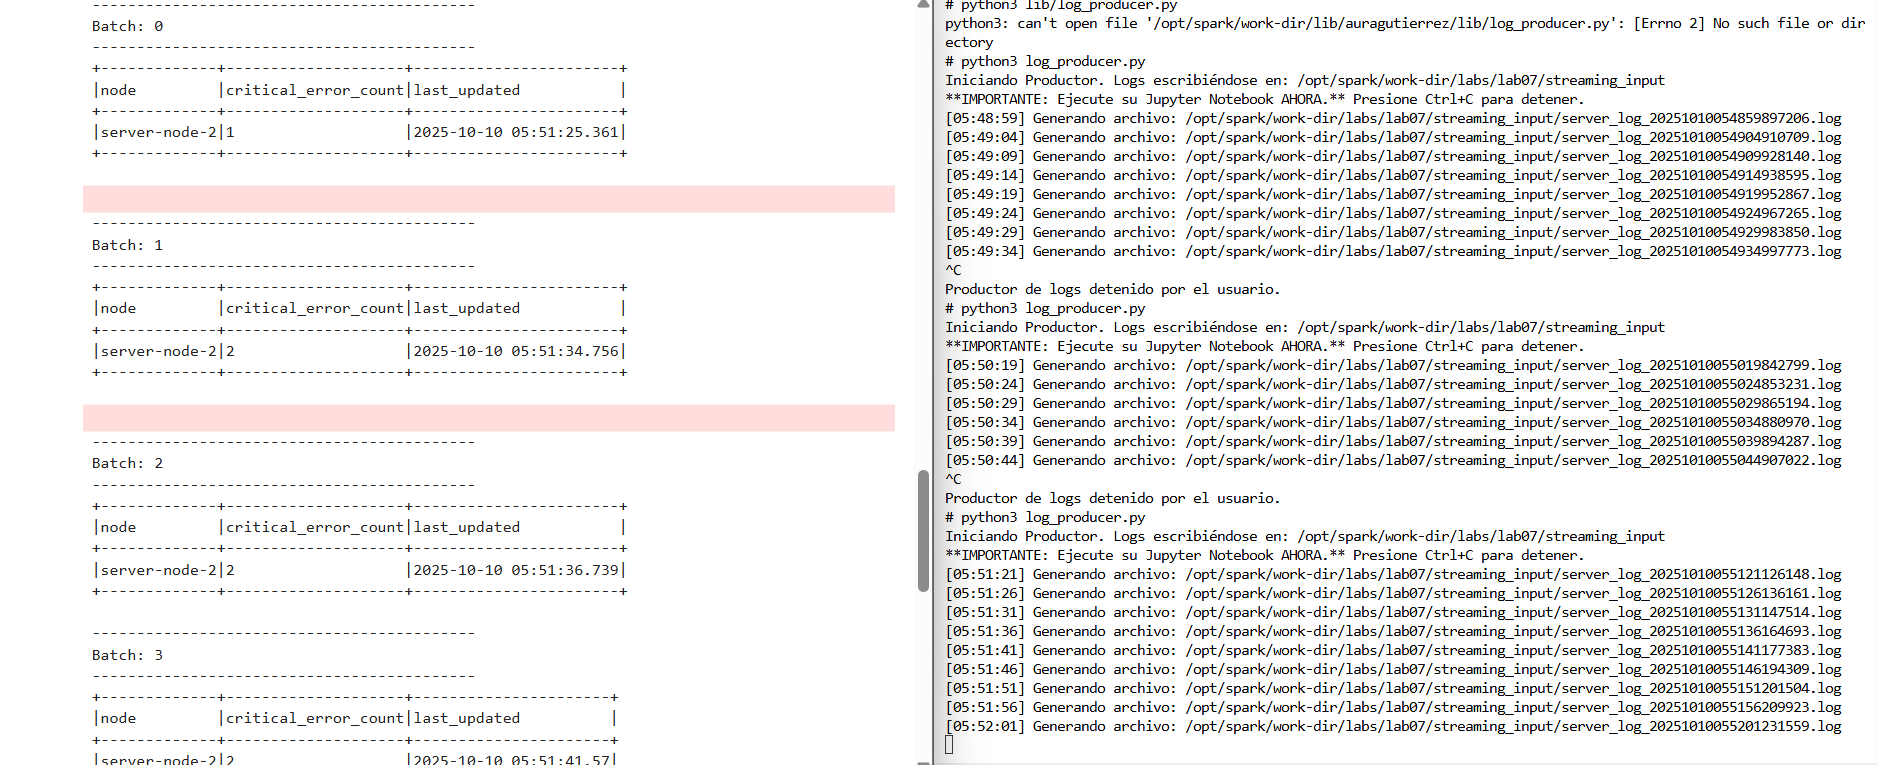

In [ ]:
sc.stop()